In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import numpy as np

# STEP 1

In [2]:
# Import kiosk point

kiosk_point = gpd.read_file('kiosk_point.shp') # 86 rows
kiosk_point.rename(columns={'Number of': 'Capacity'}, inplace=True)
kiosk_point.rename(columns={'Kiosk ID': 'ID'}, inplace=True)
kiosk_point['ID'] = kiosk_point['ID'].astype(str)

kiosk_point.head(3)

,ID,Kiosk Name,Lat,Lon,Capacity,geometry
0,11,22.5/Rio Grande,30.28620,-97.74516,4.0,POINT (-97.74516 30.28620)
1,111,23rd/San Gabriel,30.28740,-97.74780,13.0,POINT (-97.74780 30.28740)
2,3,6th/Lavaca,30.26889,-97.74525,6.0,POINT (-97.74525 30.26889)


In [3]:
# Import kiosk buffer

kiosk_buffer = gpd.read_file('kiosk_SA.shp')
kiosk_buffer['ID'] = [name.split(' :')[0] for name in kiosk_buffer['Name']]
kiosk_buffer['ID'] = kiosk_buffer['ID'].astype(str)

kiosk_buffer.head(3)

,ObjectID,FacilityID,Name,FromBreak,ToBreak,geometry,ID
0,1,1,11 : 0 - 0.19,0.0,0.19,"POLYGON ((-97.74079 30.28724, -97.74505 30.283...",11
1,2,2,111 : 0 - 0.19,0.0,0.19,"POLYGON ((-97.74805 30.28485, -97.74816 30.284...",111
2,3,3,3 : 0 - 0.19,0.0,0.19,"POLYGON ((-97.74857 30.27166, -97.74553 30.270...",3


In [4]:
# Join kiosk to kiosk buffer

kiosk_buffer = gpd.GeoDataFrame(kiosk_buffer[['ID', 'geometry']]).merge(kiosk_point[['ID', 'Kiosk Name', 'Capacity']], on='ID', how='inner')
kiosk_buffer = gpd.GeoDataFrame(kiosk_buffer, geometry='geometry')

kiosk_buffer.head(3)

,ID,geometry,Kiosk Name,Capacity
0,11,"POLYGON ((-97.74079 30.28724, -97.74505 30.283...",22.5/Rio Grande,4.0
1,111,"POLYGON ((-97.74805 30.28485, -97.74816 30.284...",23rd/San Gabriel,13.0
2,3,"POLYGON ((-97.74857 30.27166, -97.74553 30.270...",6th/Lavaca,6.0


In [5]:
# Import population

census_point = gpd.read_file('census_point.shp') # 177 rows
census_point.rename(columns={'NAME': 'name'}, inplace=True)
census_point = census_point[['name', 'POPDEN', 'geometry']]
census_point = census_point.to_crs(kiosk_buffer.crs)

census_point.head(3)

,name,POPDEN,geometry
0,Block Group 1; Census Tract 2.04; Travis Count...,2012.510,POINT (-97.74294 30.30030)
1,Block Group 5; Census Tract 10; Travis County;...,837.055,POINT (-97.73186 30.25233)
2,Block Group 1; Census Tract 20.04; Travis Coun...,5063.590,POINT (-97.78880 30.23270)


In [6]:
# Spatial join

result = gpd.sjoin(kiosk_buffer, census_point, how="inner", predicate="intersects") 
sum_pop_rate = result.groupby('ID')['POPDEN'].sum().reset_index()
sum_pop_rate.rename(columns={'POPDEN': 'pop_sum'}, inplace=True)
kiosk_buffer['pop_sum'] = kiosk_buffer['ID'].map(sum_pop_rate.set_index('ID')['pop_sum']).fillna(0)

kiosk_buffer.head(3)

,ID,geometry,Kiosk Name,Capacity,pop_sum
0,11,"POLYGON ((-97.74079 30.28724, -97.74505 30.283...",22.5/Rio Grande,4.0,30001.7
1,111,"POLYGON ((-97.74805 30.28485, -97.74816 30.284...",23rd/San Gabriel,13.0,12959.1
2,3,"POLYGON ((-97.74857 30.27166, -97.74553 30.270...",6th/Lavaca,6.0,0.0


In [7]:
# Join kiosk buffer to kiosk

kiosk_point = gpd.GeoDataFrame(kiosk_buffer[['ID', 'pop_sum']]).merge(kiosk_point[['ID', 'Capacity', 'geometry']], on='ID', how='inner')
kiosk_point = gpd.GeoDataFrame(kiosk_point, geometry='geometry')

kiosk_point.head(3)

,ID,pop_sum,Capacity,geometry
0,11,30001.7,4.0,POINT (-97.74516 30.28620)
1,111,12959.1,13.0,POINT (-97.74780 30.28740)
2,3,0.0,6.0,POINT (-97.74525 30.26889)


# Step 2

In [8]:
# Import pop buffer

pop_buffer = gpd.read_file('census_SA.shp')
pop_buffer['name'] = [name.split(' :')[0] for name in pop_buffer['Name']]

pop_buffer.head(3)

,ObjectID,FacilityID,Name,FromBreak,ToBreak,geometry,name
0,87,87,Block Group 1; Census Tract 2.04; Travis Count...,0.0,0.19,"POLYGON ((-97.74771 30.30310, -97.74531 30.301...",Block Group 1; Census Tract 2.04; Travis Count...
1,88,88,Block Group 5; Census Tract 10; Travis County;...,0.0,0.19,"POLYGON ((-97.73042 30.25079, -97.73176 30.247...",Block Group 5; Census Tract 10; Travis County;...
2,89,89,Block Group 1; Census Tract 20.04; Travis Coun...,0.0,0.19,"POLYGON ((-97.78501 30.23561, -97.78646 30.232...",Block Group 1; Census Tract 20.04; Travis Coun...


In [9]:
# Join pop to pop buffer

pop_buffer = pop_buffer[['name', 'geometry']].merge(census_point[['name', 'POPDEN']], on='name', how='inner')

pop_buffer.head(3)

,name,geometry,POPDEN
0,Block Group 1; Census Tract 2.04; Travis Count...,"POLYGON ((-97.74771 30.30310, -97.74531 30.301...",2012.510
1,Block Group 5; Census Tract 10; Travis County;...,"POLYGON ((-97.73042 30.25079, -97.73176 30.247...",837.055
2,Block Group 1; Census Tract 20.04; Travis Coun...,"POLYGON ((-97.78501 30.23561, -97.78646 30.232...",5063.590


In [10]:
# Spatial join

result = gpd.sjoin(pop_buffer, kiosk_point, how="inner", predicate="intersects") 
sum_ProToPop = result.groupby('name')['pop_sum'].sum().reset_index()
sum_ProToPop.rename(columns={'pop_sum': 'sfca'}, inplace=True)
pop_buffer['sfca'] = pop_buffer['name'].map(sum_ProToPop.set_index('name')['sfca']).fillna(0)

pop_buffer

,name,geometry,POPDEN,sfca
0,Block Group 1; Census Tract 2.04; Travis Count...,"POLYGON ((-97.74771 30.30310, -97.74531 30.301...",2012.510,0.00
1,Block Group 5; Census Tract 10; Travis County;...,"POLYGON ((-97.73042 30.25079, -97.73176 30.247...",837.055,0.00
2,Block Group 1; Census Tract 20.04; Travis Coun...,"POLYGON ((-97.78501 30.23561, -97.78646 30.232...",5063.590,0.00
3,Block Group 3; Census Tract 23.04; Travis Coun...,"POLYGON ((-97.72093 30.24704, -97.72026 30.246...",1415.350,0.00
4,Block Group 1; Census Tract 23.14; Travis Coun...,"POLYGON ((-97.72438 30.23277, -97.72165 30.229...",1262.600,0.00
...,...,...,...,...
172,Block Group 2; Census Tract 6.08; Travis Count...,"POLYGON ((-97.74350 30.28218, -97.74383 30.282...",17904.800,17904.80
173,Block Group 1; Census Tract 11.03; Travis Coun...,"POLYGON ((-97.73856 30.25640, -97.73991 30.255...",4601.930,4601.93
174,Block Group 5; Census Tract 3.02; Travis Count...,"POLYGON ((-97.73188 30.30301, -97.73227 30.301...",4807.460,0.00
175,Block Group 3; Census Tract 5; Travis County; ...,"POLYGON ((-97.73404 30.29202, -97.73534 30.291...",5803.150,0.00


In [11]:
# Divide by mean

pop_buffer['spar'] = pop_buffer['sfca'] / pop_buffer['sfca'].mean()

pop_buffer

,name,geometry,POPDEN,sfca,spar
0,Block Group 1; Census Tract 2.04; Travis Count...,"POLYGON ((-97.74771 30.30310, -97.74531 30.301...",2012.510,0.00,0.000000
1,Block Group 5; Census Tract 10; Travis County;...,"POLYGON ((-97.73042 30.25079, -97.73176 30.247...",837.055,0.00,0.000000
2,Block Group 1; Census Tract 20.04; Travis Coun...,"POLYGON ((-97.78501 30.23561, -97.78646 30.232...",5063.590,0.00,0.000000
3,Block Group 3; Census Tract 23.04; Travis Coun...,"POLYGON ((-97.72093 30.24704, -97.72026 30.246...",1415.350,0.00,0.000000
4,Block Group 1; Census Tract 23.14; Travis Coun...,"POLYGON ((-97.72438 30.23277, -97.72165 30.229...",1262.600,0.00,0.000000
...,...,...,...,...,...
172,Block Group 2; Census Tract 6.08; Travis Count...,"POLYGON ((-97.74350 30.28218, -97.74383 30.282...",17904.800,17904.80,6.763228
173,Block Group 1; Census Tract 11.03; Travis Coun...,"POLYGON ((-97.73856 30.25640, -97.73991 30.255...",4601.930,4601.93,1.738299
174,Block Group 5; Census Tract 3.02; Travis Count...,"POLYGON ((-97.73188 30.30301, -97.73227 30.301...",4807.460,0.00,0.000000
175,Block Group 3; Census Tract 5; Travis County; ...,"POLYGON ((-97.73404 30.29202, -97.73534 30.291...",5803.150,0.00,0.000000


In [12]:
# Join 2SFCA value to census tract shp file

census_tract = gpd.read_file('census.shp')
spar = census_tract[['NAME', 'geometry']].merge(pop_buffer[['name', 'POPDEN', 'sfca', 'spar']], left_on='NAME', right_on='name', how='left')
spar.to_file('spar.shp')

spar

,NAME,geometry,name,POPDEN,sfca,spar
0,Block Group 1; Census Tract 2.04; Travis Count...,"POLYGON ((-97.74777 30.29774, -97.74693 30.299...",Block Group 1; Census Tract 2.04; Travis Count...,2012.510,0.00,0.000000
1,Block Group 5; Census Tract 10; Travis County;...,"POLYGON ((-97.73727 30.25733, -97.73703 30.257...",Block Group 5; Census Tract 10; Travis County;...,837.055,0.00,0.000000
2,Block Group 1; Census Tract 20.04; Travis Coun...,"POLYGON ((-97.79163 30.23176, -97.79156 30.231...",Block Group 1; Census Tract 20.04; Travis Coun...,5063.590,0.00,0.000000
3,Block Group 3; Census Tract 23.04; Travis Coun...,"POLYGON ((-97.72695 30.24038, -97.72637 30.241...",Block Group 3; Census Tract 23.04; Travis Coun...,1415.350,0.00,0.000000
4,Block Group 1; Census Tract 23.14; Travis Coun...,"POLYGON ((-97.72766 30.22747, -97.72634 30.229...",Block Group 1; Census Tract 23.14; Travis Coun...,1262.600,0.00,0.000000
...,...,...,...,...,...,...
172,Block Group 2; Census Tract 6.08; Travis Count...,"POLYGON ((-97.74506 30.28404, -97.74495 30.285...",Block Group 2; Census Tract 6.08; Travis Count...,17904.800,17904.80,6.763228
173,Block Group 1; Census Tract 11.03; Travis Coun...,"POLYGON ((-97.74516 30.26170, -97.74501 30.262...",Block Group 1; Census Tract 11.03; Travis Coun...,4601.930,4601.93,1.738299
174,Block Group 1; Census Tract 23.24; Travis Coun...,"POLYGON ((-97.72262 30.23418, -97.72239 30.234...",Block Group 1; Census Tract 23.24; Travis Coun...,6055.550,0.00,0.000000
175,Block Group 5; Census Tract 3.02; Travis Count...,"POLYGON ((-97.73764 30.30349, -97.73730 30.304...",Block Group 5; Census Tract 3.02; Travis Count...,4807.460,0.00,0.000000


<Figure size 800x600 with 0 Axes>

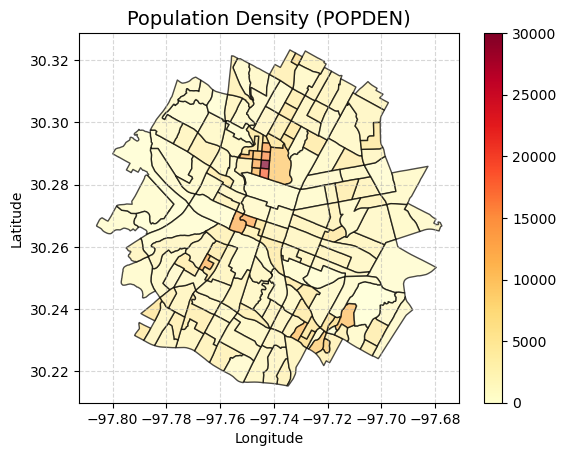

In [13]:
# population dencity map

plt.figure(figsize=(8, 6))
spar.plot(column='POPDEN', cmap='YlOrRd', legend=True, edgecolor='black', alpha=0.7)
plt.title('Population Density (POPDEN)', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<Figure size 800x600 with 0 Axes>

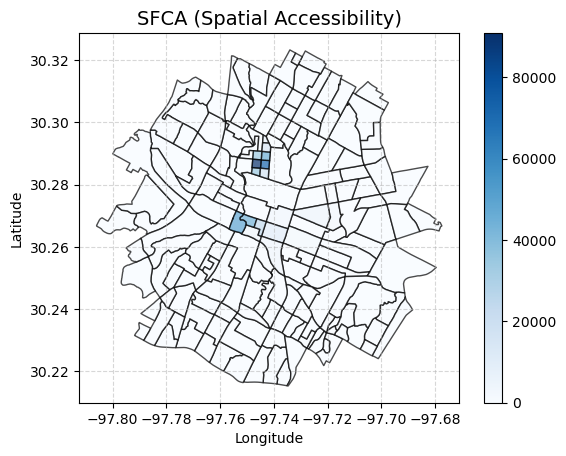

In [14]:
# SFCA (Spatial Accessibility) map

plt.figure(figsize=(8, 6))
spar.plot(column='sfca', cmap='Blues', legend=True, edgecolor='black', alpha=0.7)
plt.title('SFCA (Spatial Accessibility)', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<Figure size 800x600 with 0 Axes>

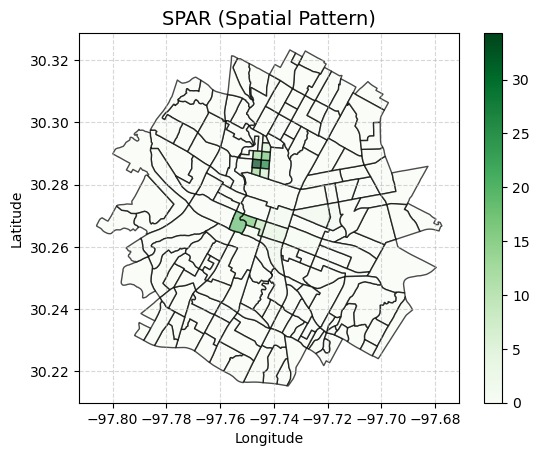

In [15]:
# SPAR (Spatial Pattern) map

plt.figure(figsize=(8, 6))
spar.plot(column='spar', cmap='Greens', legend=True, edgecolor='black', alpha=0.7)
plt.title('SPAR (Spatial Pattern)', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# VIF

In [16]:
df = pd.read_excel('regression.xlsx')
df.head(3)

,NAME,POPDEN,sfca,spar,Race1,Race2,Race3,Race4,Race5,Race6,...,Edu1,Edu2,Edu3,Edu4,Edu5,Edu6,Edu7,Trans,Income,Employ
0,Block Group 1; Census Tract 2.04; Travis Count...,2012.510,0.0,0.0,898,18,1,109,3,57,...,0,34,4,284,51,282,231,0.185535,68420,0.615087
1,Block Group 5; Census Tract 10; Travis County;...,837.055,0.0,0.0,413,19,3,31,1,96,...,80,61,46,75,0,97,135,0.074830,0,0.579882
2,Block Group 1; Census Tract 20.04; Travis Coun...,5063.590,0.0,0.0,413,35,11,35,0,42,...,186,0,317,147,9,249,27,0.011852,53510,0.704593


In [17]:
# Select independent variables (excluding the dependent variable 'spar')
X = df[['Race1','Race2','Race3','Race4','Race5','Race6','Sex1','Sex2',
        'Med_age','Edu1','Edu2','Edu3','Edu4','Edu5','Edu6','Edu7',
        'Trans','Income','Employ']]

# Add a constant (intercept term)
X = sm.add_constant(X)

# Calculate VIF (Variance Inflation Factor)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF results
print(vif)

# 

   Variable        VIF
0     const  46.964905
1     Race1   5.119372
2     Race2   2.281619
3     Race3   3.186722
4     Race4  11.996002
5     Race5   1.295669
6     Race6   3.699413
7      Sex1   8.879491
8      Sex2  15.472643
9   Med_age   1.807394
10     Edu1   1.591785
11     Edu2   1.602633
12     Edu3   7.017614
13     Edu4  17.421933
14     Edu5   1.951114
15     Edu6   7.087866
16     Edu7   4.562885
17    Trans   1.645469
18   Income   2.006733
19   Employ   1.578119


In [18]:
pca = PCA(n_components=min(X.shape[0], X.shape[1]))
pca.fit(X)

pca_results = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Variance': np.cumsum(pca.explained_variance_ratio_)
})

pca_results

,Principal Component,Explained Variance Ratio,Cumulative Variance
0,PC1,9.997866e-01,0.999787
1,PC2,1.521111e-04,0.999939
2,PC3,3.335032e-05,0.999972
3,PC4,1.043200e-05,0.999982
4,PC5,5.915719e-06,0.999988
5,PC6,3.771241e-06,0.999992
6,PC7,2.568269e-06,0.999995
7,PC8,1.595375e-06,0.999996
8,PC9,1.172314e-06,0.999997
9,PC10,9.586125e-07,0.999998


In [19]:
correlation_matrix = X.corr()
correlation_matrix

,const,Race1,Race2,Race3,Race4,Race5,Race6,Sex1,Sex2,Med_age,Edu1,Edu2,Edu3,Edu4,Edu5,Edu6,Edu7,Trans,Income,Employ
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race1,NaN,1.000000,0.204974,0.120046,0.596892,0.259155,0.075219,0.764907,0.757484,0.030415,-0.083386,0.017284,0.488994,0.564701,0.430035,0.579808,0.493246,0.164516,0.091729,0.106070
Race2,NaN,0.204974,1.000000,0.600585,0.341212,0.329151,0.604968,0.476776,0.477671,-0.238758,0.172319,0.256132,0.565991,0.455161,0.421520,-0.006229,-0.166299,0.122676,-0.254123,-0.119977
Race3,NaN,0.120046,0.600585,1.000000,0.180188,0.283322,0.753788,0.397194,0.355274,-0.219458,0.148083,0.264428,0.396106,0.313099,0.366400,0.016077,-0.186459,-0.038751,-0.249407,-0.043637
Race4,NaN,0.596892,0.341212,0.180188,1.000000,0.325004,0.213234,0.605665,0.754639,-0.334316,-0.102562,-0.085082,0.773622,0.926202,0.422263,-0.046023,-0.112128,0.450816,-0.270321,-0.180166
Race5,NaN,0.259155,0.329151,0.283322,0.325004,1.000000,0.199613,0.315431,0.332073,-0.132264,-0.021870,0.125680,0.345384,0.326408,0.193921,0.050260,0.008760,0.130825,-0.069024,0.032086
Race6,NaN,0.075219,0.604968,0.753788,0.213234,0.199613,1.000000,0.377011,0.344965,-0.214871,0.392694,0.420781,0.409405,0.317539,0.308841,-0.062778,-0.218600,0.001589,-0.269647,-0.099958
Sex1,NaN,0.764907,0.476776,0.397194,0.605665,0.315431,0.377011,1.000000,0.819807,-0.109636,0.069335,0.144032,0.683158,0.651507,0.572477,0.526567,0.378114,0.157243,-0.055967,0.103922
Sex2,NaN,0.757484,0.477671,0.355274,0.754639,0.332073,0.344965,0.819807,1.000000,-0.130441,0.055822,0.072815,0.797979,0.816232,0.560419,0.367323,0.277536,0.125977,-0.049154,-0.053003
Med_age,NaN,0.030415,-0.238758,-0.219458,-0.334316,-0.132264,-0.214871,-0.109636,-0.130441,1.000000,0.149359,0.021915,-0.251143,-0.296848,-0.115392,0.149910,0.400452,-0.277050,0.515096,0.104000


In [20]:
# Final Variable Selection

# Remove variables with VIF greater than 10 (high multicollinearity)
high_vif_vars = vif[vif["VIF"] > 10]["Variable"].tolist()

# Detect variables with correlation greater than 0.75
high_corr_vars = set()
for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if abs(correlation_matrix.loc[idx, col]) > 0.75 and col != idx:
            high_corr_vars.add(col)

# Select final variables by excluding those with high VIF and high correlation
final_vars = [var for var in X.columns if var not in high_vif_vars and var not in high_corr_vars]

# Create a DataFrame of recommended variables
final_vars_df = pd.DataFrame({'Recommended Variables': final_vars})

# Display the final recommended variables
final_vars_df

,Recommended Variables
0,Race2
1,Race5
2,Med_age
3,Edu1
4,Edu2
5,Edu5
6,Edu6
7,Edu7
8,Trans
9,Income


# Regression analysis

In [21]:
pip install stargazer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [22]:
# https://deepnote.com/app/carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a
# Load libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd


import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

from giddy.directional import Rose

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error 

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore') 
import time

In [23]:
# Load Georgia dataset 
gdf  = gpd.read_file('GWR.shp')
gdf.head(3)

,NAME,name_1,POPDEN,sfca,spar,code,Race1,Race2,Race3,Race4,Race5,Race6,Sex1,Sex2,Med_age,Edu1,Edu2,Edu3,Edu4,Edu5,Edu6,Edu7,Trans,Income,Employ,log,X,Y,geometry
0,Block Group 1; Census Tract 2.04; Travis Count...,Block Group 1; Census Tract 2.04; Travis Count...,2012.510,0.0,0.0,2.04,898,18,1,109,3,57,699,335,27.9,0,34,4,284,51,282,231,0.185535,68420,0.615087,0.0001,-97.7429,30.3003,"POLYGON ((-97.74777 30.29774, -97.74693 30.299..."
1,Block Group 5; Census Tract 10; Travis County;...,Block Group 5; Census Tract 10; Travis County;...,837.055,0.0,0.0,10,413,19,3,31,1,96,320,187,41.8,80,61,46,75,0,97,135,0.074830,0,0.579882,0.0001,-97.7319,30.2523,"POLYGON ((-97.73727 30.25733, -97.73703 30.257..."
2,Block Group 1; Census Tract 20.04; Travis Coun...,Block Group 1; Census Tract 20.04; Travis Coun...,5063.590,0.0,0.0,20.04,413,35,11,35,0,42,503,455,37.5,186,0,317,147,9,249,27,0.011852,53510,0.704593,0.0001,-97.7888,30.2327,"POLYGON ((-97.79163 30.23176, -97.79156 30.231..."


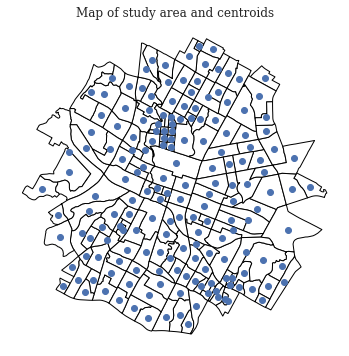

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(color = 'white', edgecolor = 'black', ax = ax)
gdf.centroid.plot(ax=ax)
ax.set_title('Map of study area and centroids', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [25]:
y = gdf['spar'].values.reshape((-1,1)) # reshape is needed to have column array
y.shape

(177, 1)

In [26]:
X = gdf[['Race2', 'Race5', 'Med_age', 'Edu1', 'Edu2', 'Edu5', 'Edu6', 'Edu7', 'Trans', 'Income', 'Employ']].values
X.shape

(177, 11)

In [27]:
u = gdf['X']
v = gdf['Y']
coords = list(zip(u,v))

In [28]:
%%time
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

CPU times: user 4.05 s, sys: 2.17 s, total: 6.22 s
Wall time: 3.46 s


In [29]:
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 175.0


In [30]:
gwr_results = GWR(coords, y, X, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 177
Number of covariates:                                                    12

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2687.401
Log-likelihood:                                                    -491.888
AIC:                                                               1007.776
AICc:                                                              1012.009
BIC:                                                               1833.337
R2:                                                                   0.168
Adj. R2:                                                              0.113

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [31]:
# As reference, here is the (average) R2, AIC, and AICc
print('Mean R2 =', gwr_results.R2)
print('AIC =', gwr_results.aic)
print('AICc =', gwr_results.aicc)

Mean R2 = 0.29662234199492066
AIC = 999.9206114612861
AICc = 1007.0609199352069


In [32]:
# Add R2 to GeoDataframe 
gdf['gwr_R2'] = gwr_results.localR2

In [33]:
gdf

,NAME,name_1,POPDEN,sfca,spar,code,Race1,Race2,Race3,Race4,Race5,Race6,Sex1,Sex2,Med_age,Edu1,Edu2,Edu3,Edu4,Edu5,Edu6,Edu7,Trans,Income,Employ,log,X,Y,geometry,gwr_R2
0,Block Group 1; Census Tract 2.04; Travis Count...,Block Group 1; Census Tract 2.04; Travis Count...,2012.510,0.00,0.000000,2.04,898,18,1,109,3,57,699,335,27.9,0,34,4,284,51,282,231,0.185535,68420,0.615087,0.0001,-97.7429,30.3003,"POLYGON ((-97.74777 30.29774, -97.74693 30.299...",0.301246
1,Block Group 5; Census Tract 10; Travis County;...,Block Group 5; Census Tract 10; Travis County;...,837.055,0.00,0.000000,10,413,19,3,31,1,96,320,187,41.8,80,61,46,75,0,97,135,0.074830,0,0.579882,0.0001,-97.7319,30.2523,"POLYGON ((-97.73727 30.25733, -97.73703 30.257...",0.341167
2,Block Group 1; Census Tract 20.04; Travis Coun...,Block Group 1; Census Tract 20.04; Travis Coun...,5063.590,0.00,0.000000,20.04,413,35,11,35,0,42,503,455,37.5,186,0,317,147,9,249,27,0.011852,53510,0.704593,0.0001,-97.7888,30.2327,"POLYGON ((-97.79163 30.23176, -97.79156 30.231...",0.343055
3,Block Group 3; Census Tract 23.04; Travis Coun...,Block Group 3; Census Tract 23.04; Travis Coun...,1415.350,0.00,0.000000,23.04,1367,101,0,172,1,103,1013,495,29.9,0,0,0,107,65,922,222,0.067343,81703,0.915782,0.0001,-97.7207,30.2427,"POLYGON ((-97.72695 30.24038, -97.72637 30.241...",0.322141
4,Block Group 1; Census Tract 23.14; Travis Coun...,Block Group 1; Census Tract 23.14; Travis Coun...,1262.600,0.00,0.000000,23.14,240,148,10,29,0,128,140,40,28.5,0,20,30,0,32,98,0,0.000000,0,0.722222,0.0001,-97.7242,30.2311,"POLYGON ((-97.72766 30.22747, -97.72634 30.229...",0.319083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Block Group 2; Census Tract 6.08; Travis Count...,Block Group 2; Census Tract 6.08; Travis Count...,17904.800,17904.80,6.763228,6.08,1505,89,5,646,3,91,640,1133,20.0,0,1,438,759,78,121,49,0.413876,22419,0.471517,17904.8000,-97.7434,30.2837,"POLYGON ((-97.74506 30.28404, -97.74495 30.285...",0.315876
173,Block Group 1; Census Tract 11.03; Travis Coun...,Block Group 1; Census Tract 11.03; Travis Coun...,4601.930,4601.93,1.738299,11.03,1902,95,3,168,0,66,1149,1458,46.9,90,77,32,100,74,1407,667,0.069343,161903,0.735712,4601.9300,-97.7398,30.2579,"POLYGON ((-97.74516 30.26170, -97.74501 30.262...",0.349069
174,Block Group 1; Census Tract 23.24; Travis Coun...,Block Group 1; Census Tract 23.24; Travis Coun...,6055.550,0.00,0.000000,23.24,177,201,6,89,0,74,775,155,20.9,0,20,25,339,0,0,0,0.373134,88574,0.648387,0.0001,-97.7200,30.2358,"POLYGON ((-97.72262 30.23418, -97.72239 30.234...",0.317146
175,Block Group 5; Census Tract 3.02; Travis Count...,Block Group 5; Census Tract 3.02; Travis Count...,4807.460,0.00,0.000000,3.02,703,22,9,113,5,40,840,276,28.5,0,29,0,227,11,269,238,0.375143,50543,0.785842,0.0001,-97.7347,30.3035,"POLYGON ((-97.73764 30.30349, -97.73730 30.304...",0.295675


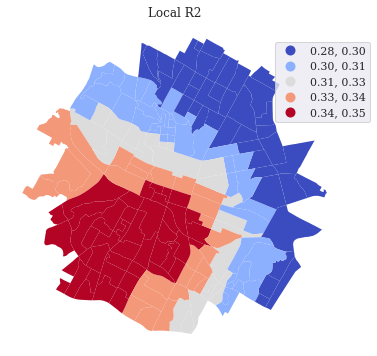

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(column='gwr_R2', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local R2', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [35]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# GWR
# gwr_results = GWR(coords, y, X, gwr_bw).fit()

# Extract Local R² and Parameter
local_r2 = gwr_results.localR2
params = gwr_results.params

# Create dataFrame
results_df = pd.DataFrame(params, columns=['Intercept'] + [f'Coef_{i}' for i in range(1, params.shape[1])])
results_df['Local_R2'] = local_r2

# Add geometry to GeoDataFrame
geometry = [Point(xy) for xy in coords]
gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs="EPSG:4326")  # 좌표계 설정

# Export shp
output_shp = "gwr_results.shp"
#gdf.to_file(output_shp, driver="ESRI Shapefile")

In [36]:
gdf

,Intercept,Coef_1,Coef_2,Coef_3,Coef_4,Coef_5,Coef_6,Coef_7,Coef_8,Coef_9,Coef_10,Coef_11,Local_R2,geometry
0,12.416939,-0.002054,-0.534216,-0.182279,-0.008029,-0.007838,-0.002063,0.003401,0.002375,6.797011,-0.000003,-9.839933,0.301246,POINT (-97.74290 30.30030)
1,4.002543,-0.006597,-0.128972,-0.035827,-0.006981,-0.004158,0.004222,0.003478,0.002267,12.667425,-0.000002,-6.067934,0.341167,POINT (-97.73190 30.25230)
2,5.239489,-0.006410,-0.122602,-0.082622,-0.006895,-0.005547,0.000270,0.003924,0.002403,11.807100,-0.000004,-5.429986,0.343055,POINT (-97.78880 30.23270)
3,2.862525,-0.005544,-0.078516,-0.020290,-0.005646,-0.002773,0.004116,0.002744,0.002296,11.444278,-0.000001,-5.008130,0.322141,POINT (-97.72070 30.24270)
4,2.511605,-0.005353,-0.042025,-0.018875,-0.005274,-0.002738,0.003539,0.002702,0.002505,11.125572,-0.000002,-4.562729,0.319083,POINT (-97.72420 30.23110)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,11.598726,-0.003316,-0.512501,-0.169553,-0.009819,-0.006363,-0.001531,0.004147,0.002550,8.448921,-0.000003,-9.704225,0.315876,POINT (-97.74340 30.28370)
173,5.648763,-0.007217,-0.204773,-0.063768,-0.009314,-0.005774,0.003192,0.004265,0.002261,13.164989,-0.000003,-7.090639,0.349069,POINT (-97.73980 30.25790)
174,2.485594,-0.005327,-0.048794,-0.015810,-0.005504,-0.002556,0.003895,0.002612,0.002492,11.085384,-0.000002,-4.664679,0.317146,POINT (-97.72000 30.23580)
175,11.593330,-0.002354,-0.512843,-0.165853,-0.006492,-0.007752,-0.000546,0.002962,0.001987,6.893739,-0.000003,-9.313462,0.295675,POINT (-97.73470 30.30350)
